# Final Project - Shawn Feng, Will Novak, Eddie Loyd

In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
filenames = glob.glob('midi_data/*/**/*.mid', recursive=True)
sample_file = filenames[1]  # Change this to the desired MIDI file
#sample_file = "midi_data\progressions\I-VI-ii-V-maj\A-5-I-VI-ii-V-maj-46.mid"
#sample_file = "midi_data\scales\ionian\G-4ionian-3.mid"
sample_file

'midi_data\\arpeggios\\aug\\A-1-aug-arpeggio-1.mid'

In [3]:
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm)

In [4]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    _SAMPLING_RATE = 16000
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [5]:
display_audio(pm)

In [6]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [7]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,37,0.0,1.0,0.0,1.0
1,41,1.0,2.0,1.0,1.0
2,45,2.0,3.0,1.0,1.0


In [8]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#2', 'F2', 'A2'], dtype='<U3')

In [9]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

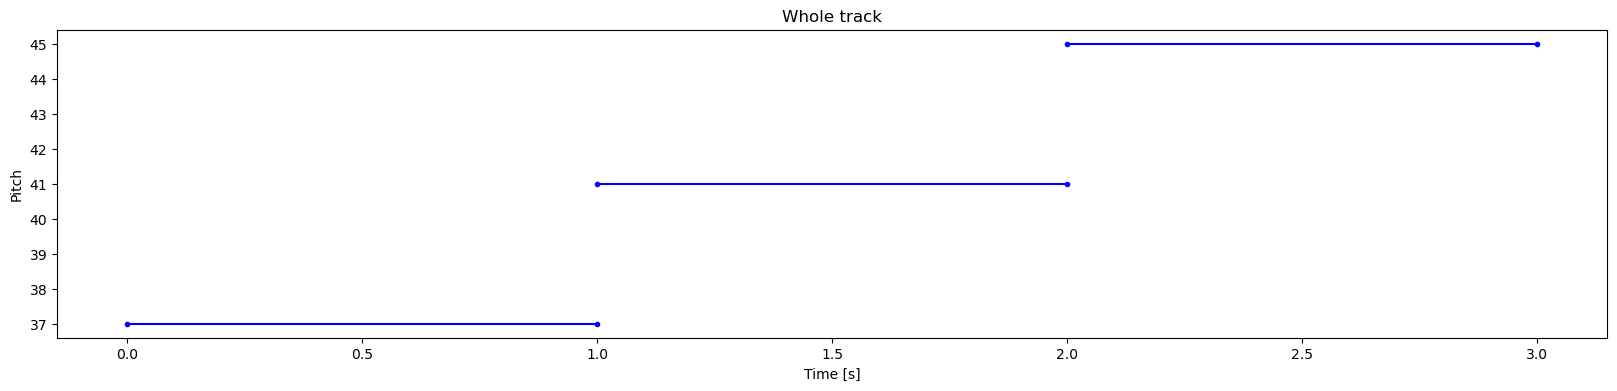

In [10]:
plot_piano_roll(raw_notes)

In [11]:
import random
random.shuffle(filenames)

In [12]:
num_files = 1000
all_notes = []
for f in filenames[:num_files]:
    try:
        notes = midi_to_notes(f)
        all_notes.append(notes)
    except:
        print(f)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
n_notes

midi_data\progressions\I-i#-ii-V\B-7-I-i#-ii-V-30.mid
midi_data\progressions\i-vi-ii-V-min\C-8-i-vi-ii-V-min-218.mid
midi_data\progressions\I-VI-ii-V-maj\C-8-I-VI-ii-V-maj-148.mid
midi_data\progressions\i-vi-ii-V-min\B-7-i-vi-ii-V-min-118.mid
midi_data\progressions\ii-V-I-maj\B-7-ii-V-I-maj-8.mid
midi_data\progressions\i-vi-ii-V-min\B-7-i-vi-ii-V-min-230.mid
midi_data\progressions\ii-V-I-maj\Bb-7-ii-V-I-maj-28.mid
midi_data\progressions\ii#-V#-ii-V\A-7-ii#-V#-ii-V-90.mid
midi_data\progressions\ii#-V#-ii-V\C-8-ii#-V#-ii-V-162.mid
midi_data\progressions\ii-V-I-maj\Ab-7-ii-V-I-maj-47.mid
midi_data\progressions\iii-VI-ii-V\Bb-7-iii-VI-ii-V-66.mid
midi_data\progressions\I-IV7-iii-VI7\Bb-7-I-IV7-iii-VI7-42.mid
midi_data\progressions\i-vi-ii-V-min\B-7-i-vi-ii-V-min-217.mid
midi_data\progressions\iii-VI-ii-V\A-7-iii-VI-ii-V-47.mid
midi_data\progressions\I-VI-ii-V-maj\B-7-I-VI-ii-V-maj-232.mid
midi_data\progressions\I-IV7-iii-VI7\B-7-I-IV7-iii-VI7-167.mid
midi_data\progressions\iii-VI-ii-V\B-7-

14100

In [13]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
train_notes

array([[47.,  0.,  2.],
       [51.,  0.,  2.],
       [54.,  0.,  2.],
       ...,
       [28.,  0.,  2.],
       [31.,  0.,  2.],
       [35.,  0.,  2.]])

In [14]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [15]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                                drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [17]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [18]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [19]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [20]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [21]:
%%time
epochs = 25

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/25
219/219 [==============================] - 30s 79ms/step - loss: 0.8138 - duration_loss: 0.0517 - pitch_loss: 4.5663 - step_loss: 0.5338
Epoch 2/25
219/219 [==============================] - 14s 63ms/step - loss: 0.4207 - duration_loss: 0.0217 - pitch_loss: 4.4850 - step_loss: 0.1748
Epoch 3/25
219/219 [==============================] - 14s 66ms/step - loss: 0.3063 - duration_loss: 0.0156 - pitch_loss: 4.3545 - step_loss: 0.0729
Epoch 4/25
219/219 [==============================] - 15s 67ms/step - loss: 0.2779 - duration_loss: 0.0140 - pitch_loss: 4.1727 - step_loss: 0.0553
Epoch 5/25
219/219 [==============================] - 14s 66ms/step - loss: 0.2613 - duration_loss: 0.0141 - pitch_loss: 3.9716 - step_loss: 0.0487
Epoch 6/25
219/219 [==============================] - 15s 68ms/step - loss: 0.2461 - duration_loss: 0.0127 - pitch_loss: 3.8275 - step_loss: 0.0420
Epoch 7/25
219/219 [==============================] - 15s 68ms/step - loss: 0.2388 - duration_loss: 0.0125 - pit

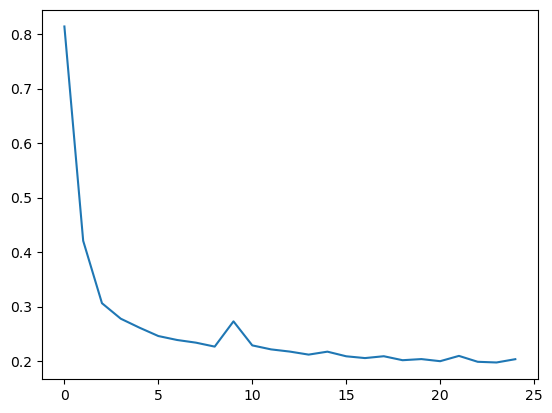

In [22]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [23]:
def predict_next_note(
        notes: np.ndarray, 
        model: tf.keras.Model, 
        temperature: float = 1.0) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [24]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

In [25]:
input_notes.shape

(25, 3)

In [26]:
generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
        generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 78ms/step


In [27]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,71,0.021989,1.988169,0.021989,2.010158
1,107,2.147590,2.223894,2.169579,4.393473
2,118,2.152666,2.350952,4.322245,6.673197
3,118,2.151114,2.387961,6.473359,8.861321
4,113,2.152102,2.400797,8.625462,11.026259
5,111,2.154498,2.412722,10.779959,13.192681
6,120,2.152221,2.423969,12.932180,15.356149
7,113,2.150913,2.421253,15.083093,17.504346
8,109,2.148336,2.436494,17.231429,19.667923
9,117,2.150364,2.444691,19.381794,21.826484


In [28]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str, 
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [29]:
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
instrument_name

'Acoustic Grand Piano'

In [30]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

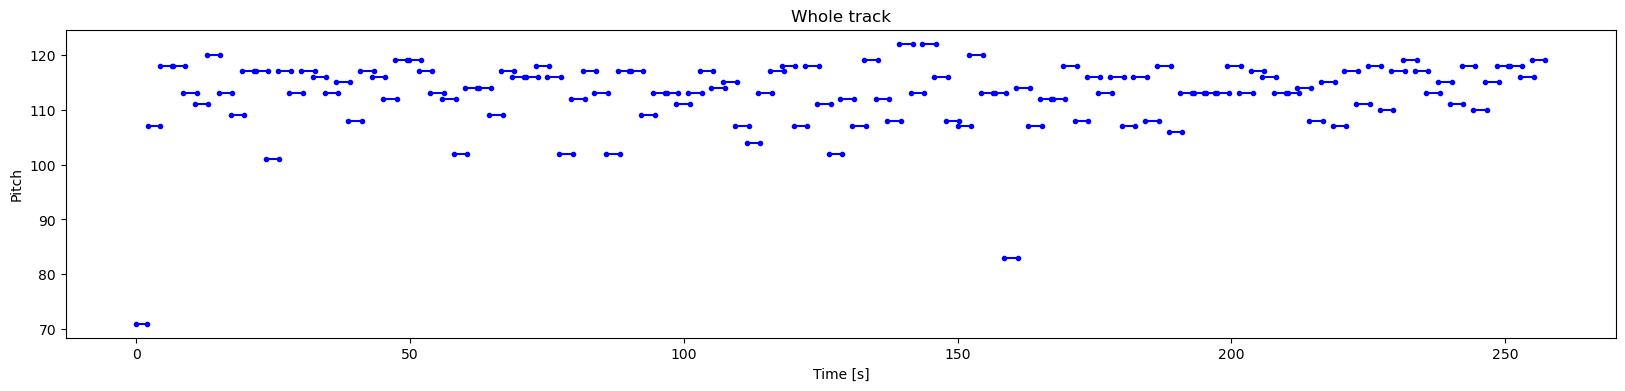

In [31]:
plot_piano_roll(generated_notes)

In [32]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

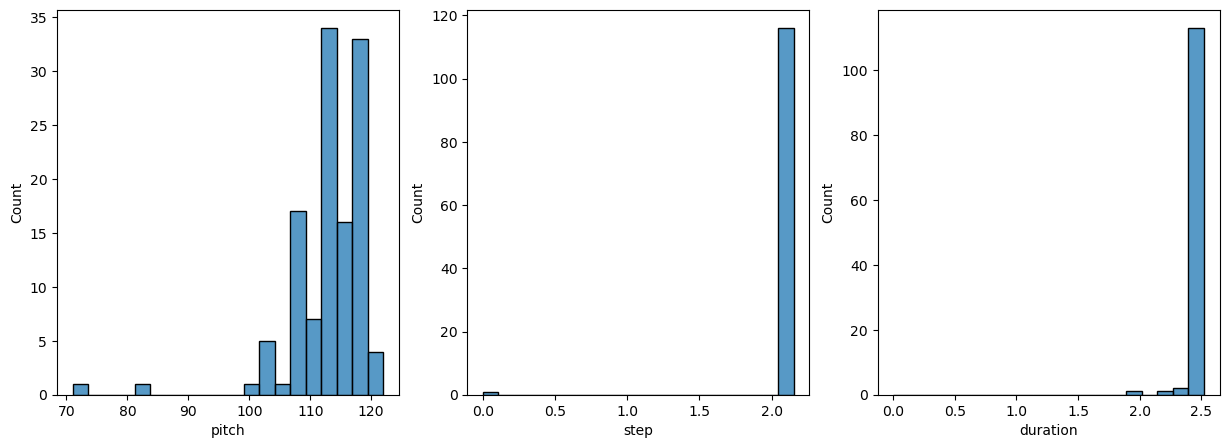

In [33]:
plot_distributions(generated_notes)